In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;  
}

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('/Users/af/Work/code/mcmc/build')
#sys.path.append('/Users/af/Work/code/mcmc/debug')

import mcmc
#help(mcmc)
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

['China' 'France' 'Italy' 'Korea, South' 'Spain' 'US']
DatetimeIndex(['2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24',
               '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
               '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03',
               '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07',
               '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11',
               '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15',
               '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19',
               '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
               '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
               '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
               '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
               '2020-04-09', '2020-04-10', '2020-04-11', '2020-04-12',
               '2020-0

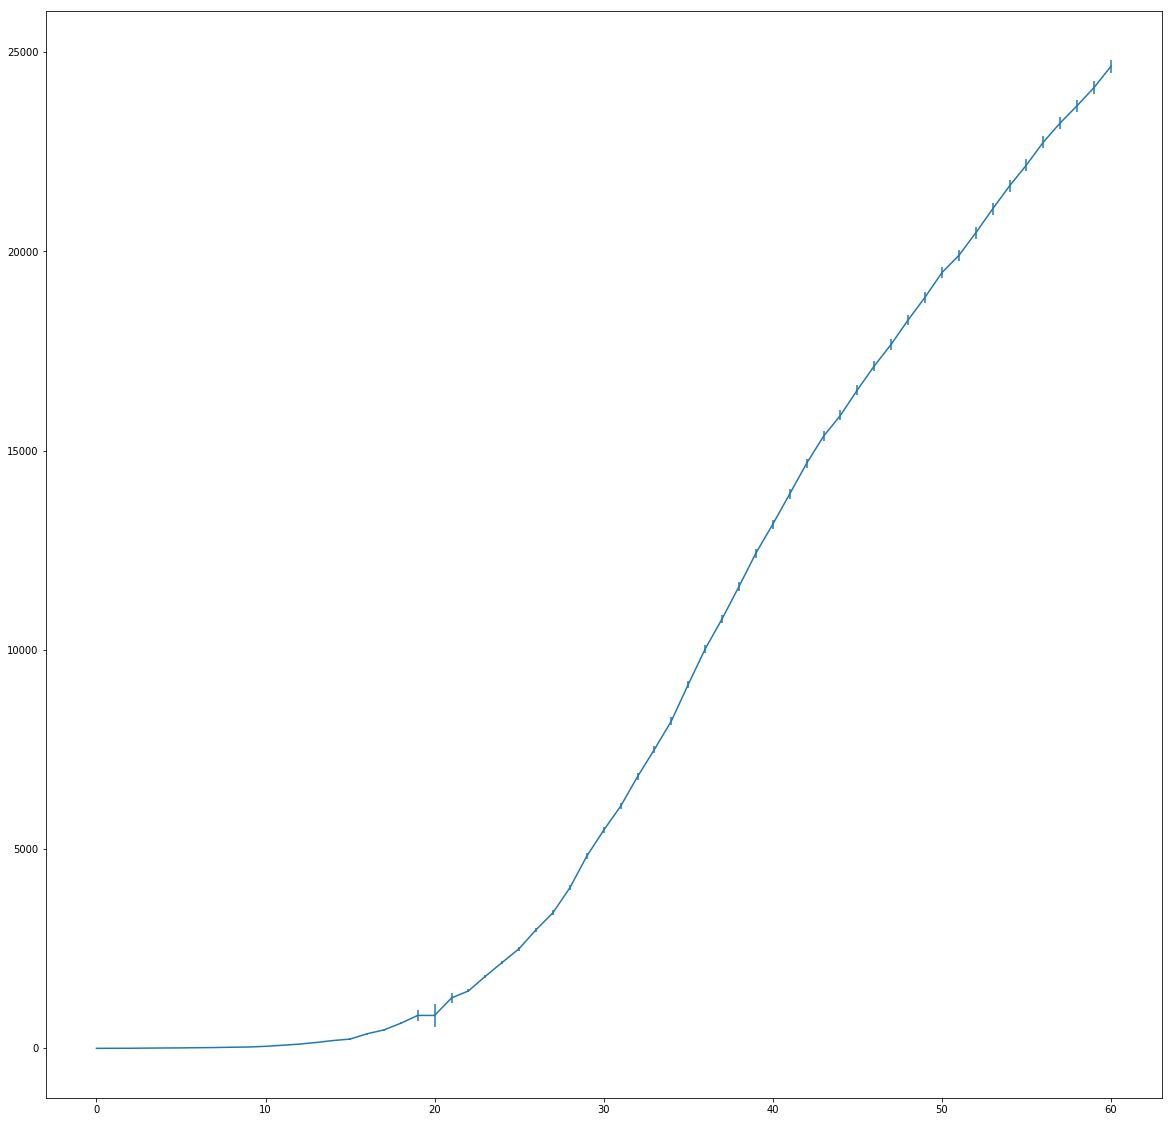

In [3]:
import pandas as pd
from datetime import datetime,timedelta
giturl_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

corona_cases_df=pd.read_csv(giturl_deaths, index_col=[0,1,2,3])  
#   use first four columns as multiindex




country_official_list = (corona_cases_df.index.get_level_values('Country/Region').values)

wanted_countries = ['China', 'Korea','Italy', 'France', 'US', 'Spain']

countries_list = [np.unique(np.array([s for s in country_official_list if cou in s])) 
                                                 for cou in wanted_countries]
countries_list = np.array(countries_list).flatten()
countries_list.sort()
print(countries_list)


cases_percountry = {}
df_dict = {}
for country in countries_list:
    cou = corona_cases_df.loc[pd.IndexSlice[:, country], :].sum()
    cases_percountry[country] = cou[cou > 0]
    datesformat = [datetime.strptime(da, '%m/%d/%y') 
                   for da in cases_percountry[country].index]
    
    df_dict[country] = pd.DataFrame(cases_percountry[country], 
                                    columns=['Cases'], index=datesformat)
    df_dict[country]['DayCount'] = np.arange(1, 
                                             cases_percountry[country].shape[0]+1)
    
    
country = 'Korea, South'
country = 'Spain'
country = 'Italy'

print(df_dict[country].index)
#print(df_dict['Italy']['Cases'])  #print cases every three days

# for country in countries_list:
#     print(country)
#     dates=df_dict[country].index
#     plt.semilogy(dates, np.array(list(df_dict[country]['Cases'].values)), label=country)
#     plt.legend(loc='lower right')
#     plt.tick_params(rotation=45, labelsize=12)
#     #plt.ylabel(casestr, fontsize=14)
# plt.xlim([dates[0]-np.timedelta64(3,'D'), dates[-1]+np.timedelta64(10,'D')])
# plt.show()

if country == 'Italy':
    nPop = 60260000
    icuBeds = 7500
if country == 'Spain':
    nPop = 46722000
    icuBeds = 3500
if country == 'France':
    nPop = 67000000
    icuBeds = 7000
    
nPredictDays = 10
maxdelay = 42

#testdays = np.arange(60)

#starting at 21 feb 

#print(np.array(list(df_dict[country]['Cases'].values)))
deaths_data = np.array(list(df_dict[country]['Cases'].values))


#deaths_data = deaths_data[:-4]





#np.array([1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476,6077,6820,7503,8215,9134,10023,10779,11591,12428,13155,13915, 14681, 15362 ])
#nPop/(1+np.exp(-(testdays-20)*0.2))*0.0015

deaths_past = np.zeros(maxdelay + deaths_data.size)
deaths_past[maxdelay:] = deaths_data
#keep the relative error low at 1%. if all measurements were independent it would be low.
#but errors even out in time mostly - here we assume a tiny fraction of cases does not 
#besides the constant 

#shot noise: every delta has sigma = sqrt(delta). day i var is cumsum of sigma^2=delta, so the original total. 
#constant unnoticed deaths are fitted for
#assume additional 10% attribution error in the numbers of each day, which however are supposed to be cancelled by anticorrelated erros in 
#the next 2 days instead of accumulating 

shotnoise = np.sqrt(deaths_data)
deaths_error = shotnoise

perday = np.diff(deaths_data)
deaths_error[1:] += 0*0.05*perday 

#unnoticed = 3*np.ones(deaths_data.shape)
#unnoticed[14:] = 0
 #np.cumsum(unnoticed) + shotnoise

if country == 'Italy':
    deaths_error[19] += 100
    deaths_error[20] += 250
    deaths_error[21] += 100
    
    
time_past = np.arange(deaths_past.size)-maxdelay
time_data = np.arange(deaths_data.size)
time_all = np.arange(deaths_past.size+nPredictDays)-maxdelay


#plt.plot(time_past, deaths_past)
plt.figure(figsize=(20,20))
plt.errorbar(time_data, deaths_data, deaths_error)



deathdata = np.zeros((2, deaths_data.size))
deathdata[0, :] = deaths_data
deathdata[1, :] = deaths_error

if country == 'Italy':
    discontdays = np.array([1, 9, 12, 29]) #removed 32 
    discontvals = np.array([0.99,0.3,0.3,0.2]) 
if country == 'Spain':
    discontdays = np.array([8, 10, 25]) #removed 32 
    discontvals = np.array([1,0.6,0.2])
if country == 'France':
    discontdays = np.array([22, 28, 30, 31]) #removed 32 
    discontvals = np.array([1,0.8,0.2, 0.1])

discontdata = np.zeros((3, discontdays.size))
discontdata[0, :] = discontdays
discontdata[1, :] = discontvals
discontdata[2, :] = discontvals # > 0 means sample this (else fixed)
#discontdata[2, 1] = -1         # < 0 means fix 

data = mcmc.DiseaseData(deathdata,  discontdata)

In [ ]:
params = mcmc.DiseaseParams()
params.probLethalDailyWhenSeriousUntreated = 0.4
params.probSerious = 0.045 #unknown, higher for older population - should be possible to extract from Diamond Princess. 
#I think about 30 were serious... 30/700 would then be upper limit, so at most 5% for old people. 
#Conistency check: 6(factor below)*11(dead on diamond princess) = 66... okay, more than 30. So 10% serious for old people.
# this number is between 0.02 and 0.1. need to line search max likelihood

params.probLethal = params.probSerious*0.13 #out of 50~49 serious cases, 7 dead in Aachen study https://www.aerzteblatt.de/archiv/213454
params.probAsymp = 0.375
params.timeIncub = 6  #chinese like studies...
params.timeIncubSigma = 4

#obained to match median 4, IQR 7 from Aachen study https://www.aerzteblatt.de/archiv/213454
params.timeMildToSerious = 7.1 
params.timeMildToSeriousSigma = 13

#Drosten study https://www.medrxiv.org/content/10.1101/2020.03.05.20030502v1 
#: 9 patients, all virus present after 5 days of symptoms. Let's say then that chance shorter ~ 10%. 
# seroconversion early week 2 progressive decrease in viral load in samples. 10 days most gone. 
#let's take lognormal with 5 at 10% CDF and 10 at 90% CDF 
params.timeMildDuration = 7.4 
params.timeMildDurationSigma = 2

# Aachen Median acht Tage (IQR 5–11) for all, including most that did not die. 
# This is longer with larger spread than the recovered group. We choose Median 8.6, IQR 6.6 to get 
params.timeSeriousToDeath = 10
params.timeSeriousToDeathSigma = 6

# less important: 
# Aachen Median 7 Tage [IQR 6–11])
params.timeSeriousToRecovered = 8
params.timeSeriousToRecoveredSigma = 4.5

params.proxyTincub = 8
params.proxyTinfec = 14

#data.initialBetaMild = 3.38/4
#data.initialBetaHigh = 5.05/4
data.initialMild0 = 4500+1000
data.initialHigh0 = 5200+1000
data.initialDelay = 40.0-20
data.initialMissedDeaths = 10



data.fixBehaviorInAdvance = 10


covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, 1, maxdelay, nPredictDays)

covid.computeR = False

state = mcmc.State()
state.add(covid)
smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
#state.add(smooth)

#print(state.getAll())
state.sharedDependencyMaxDepth = 2

# target = mcmc.TempTarget(2)
# target.set_posterior(state)
# chain = mcmc.Chain(target, 0)
# chain.computeMean = False
# chain.recordSamples = True
# chain.run(1000000,100000,80,1000)

target = mcmc.Target()
target.set_posterior(state)
#chains = mcmc.ChainManager(target, 12000, 20)
#chains.generate_ICs_from_chain(6, 10000, 100)
#chains.run_chains(10000, 50)

chains = mcmc.ChainManager(target, 100, 3)
chains.generate_ICs_from_chain(4, 1000, 100)
chains.run_chains(10000, 50)

print(chains.get_getLoglikes()[-1])


covid = mcmc.DiseaseSpread(data, params, nPop, icuBeds, 100, maxdelay, nPredictDays)
covid.computeR = True
state = mcmc.State()
state.add(covid)
smooth = mcmc.SmoothnessPrior("behavior", 50, deaths_data.size-data.fixBehaviorInAdvance)
#state.add(smooth)



# target = mcmc.AdvCoolingTarget(15, 5)
# target.minOscillations = 8
# target.maxPeriodLength = 6
# target.set_posterior(state)
# chain = mcmc.Chain(target, 0)
# chain.computeMean = False
# chain.recordSamples = True
# chain.run(0,0,5000,20)


In [ ]:
plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())


In [ ]:
plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())


26.98555103908976
791


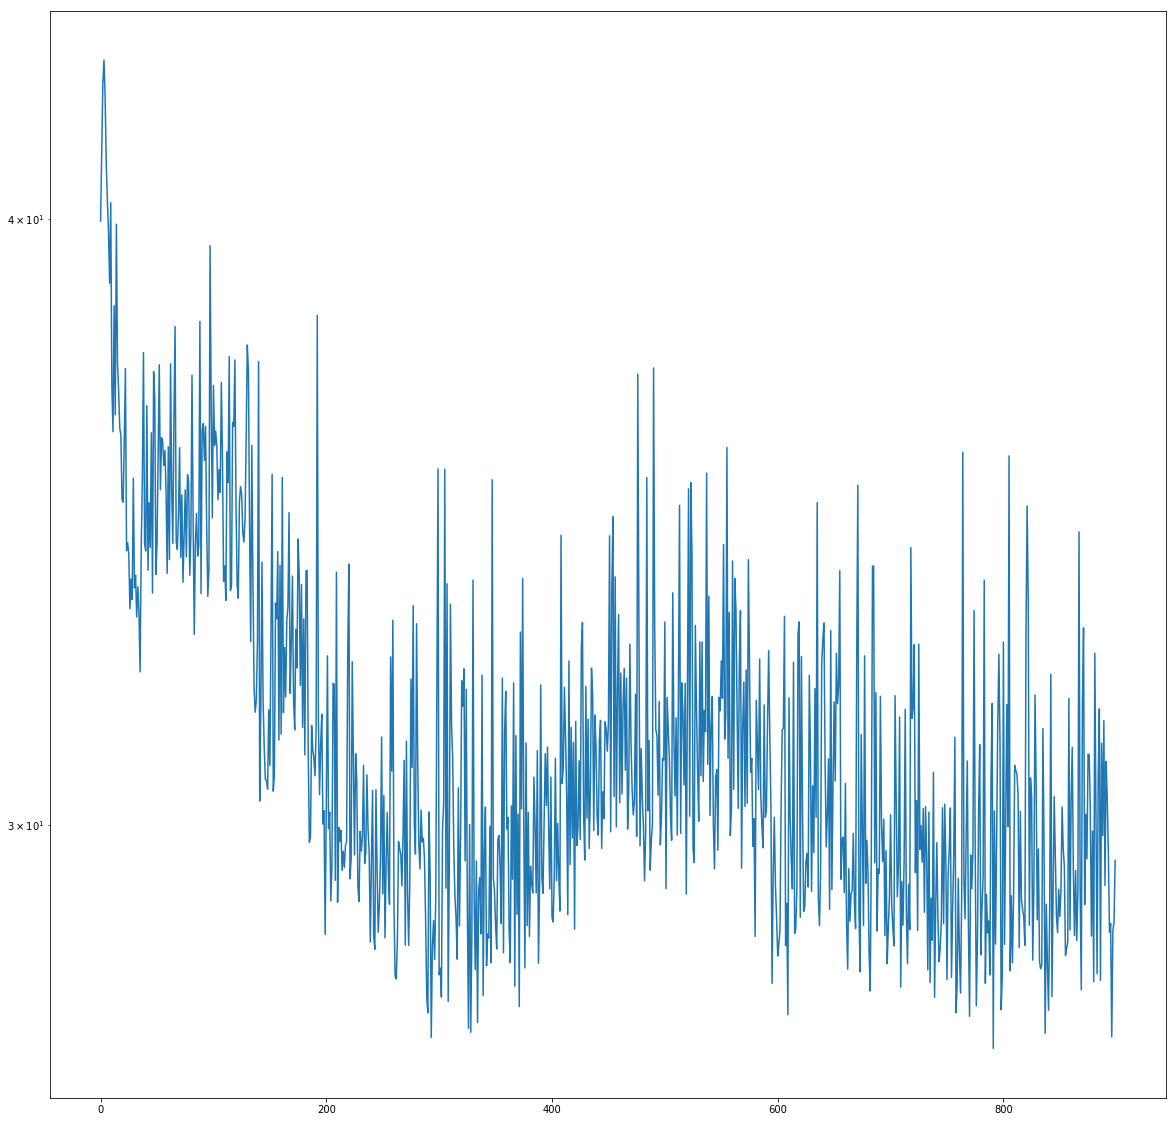

In [5]:
plt.figure(figsize=(20,20))
print(np.min(-chain.getLoglikes()))
print(np.argmin(-chain.getLoglikes()))
plt.semilogy(-chain.getLoglikes())


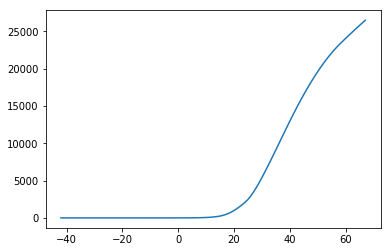

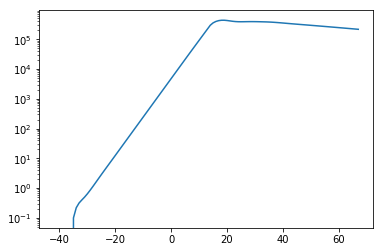

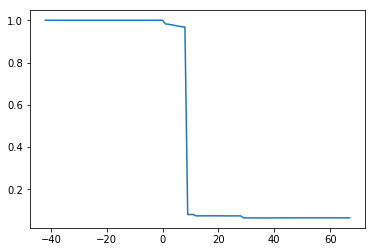

In [7]:
plt.plot(time_all[0:120], chain.getSamples("dead")[-1,0:120])
plt.show()
plt.semilogy(time_all[0:120], chain.getSamples("mildlyInfectious")[-1,0:120])
plt.show()
plt.plot(time_all[0:120], chain.getSamples("totalBehavior")[-1,0:120])

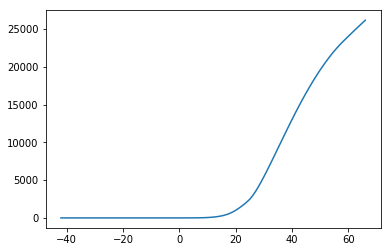

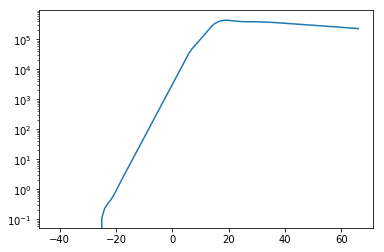

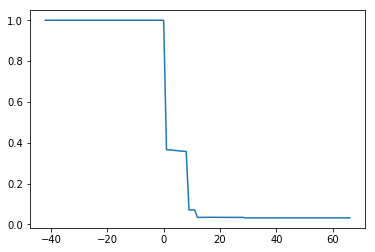

In [6]:
plt.plot(time_all[0:120], chain.getSamples("dead")[-1,0:120])
plt.show()
plt.semilogy(time_all[0:120], chain.getSamples("mildlyInfectious")[-1,0:120])
plt.show()
plt.plot(time_all[0:120], chain.getSamples("totalBehavior")[-1,0:120])

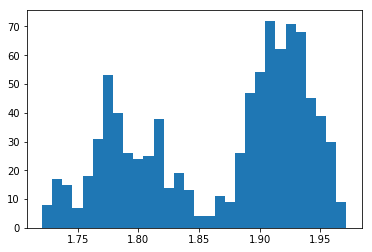

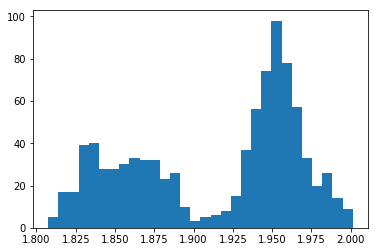

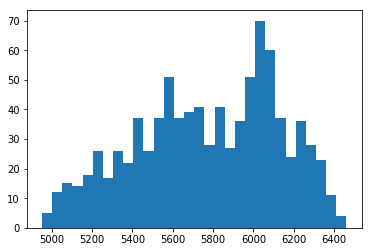

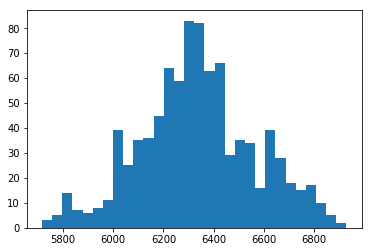

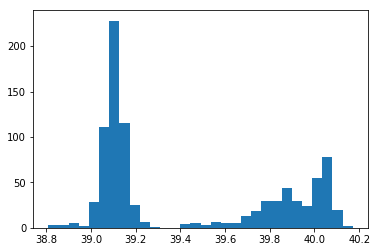

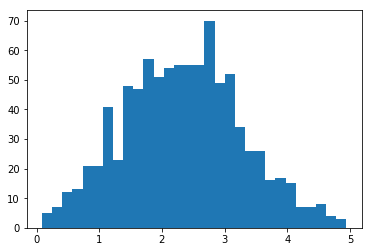

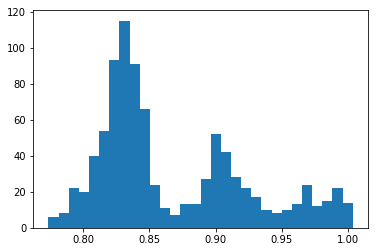

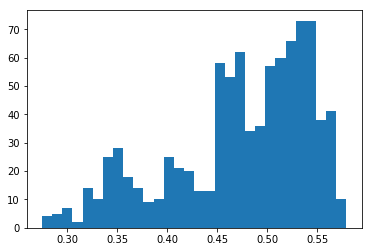

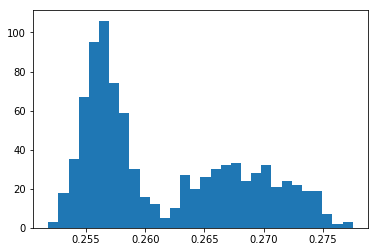

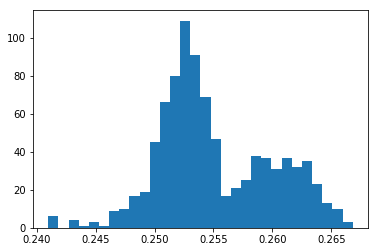

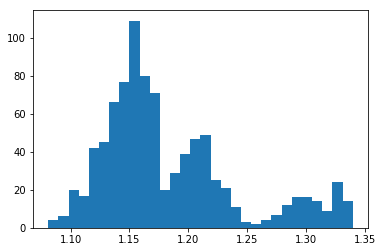

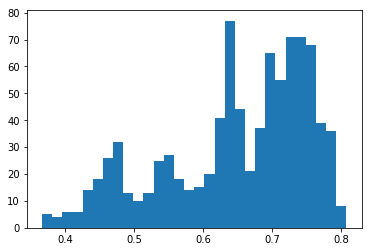

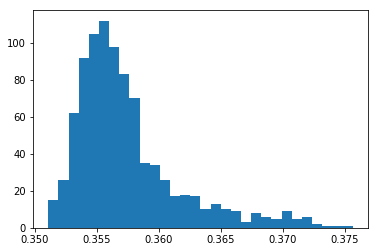

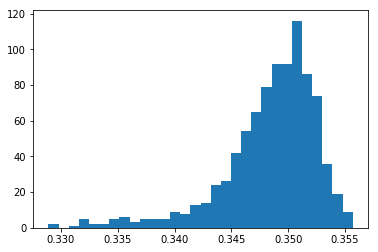

In [8]:
begin = 0
end = -1
nBin = 30

plt.hist(chain.getSamples("betaMild")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("betaHigh")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("mild0")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("high0")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("delay")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("missedDeaths")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousVals")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 3], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 3], nBin)
plt.show()

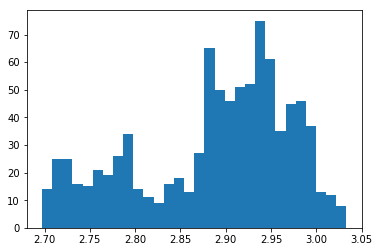

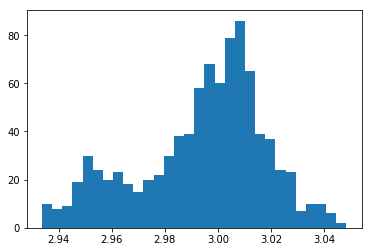

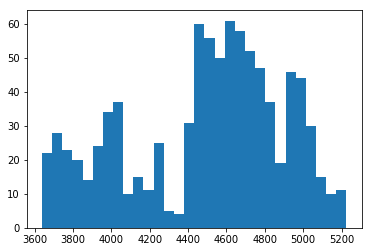

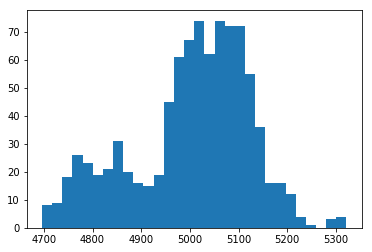

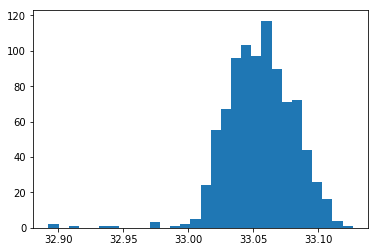

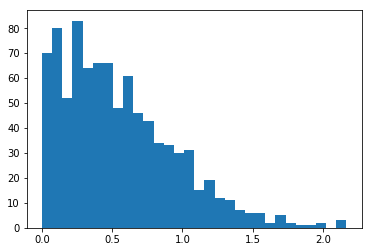

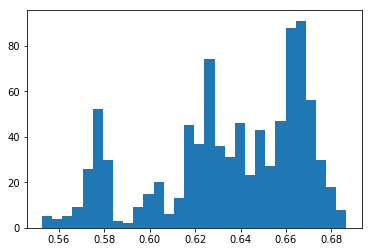

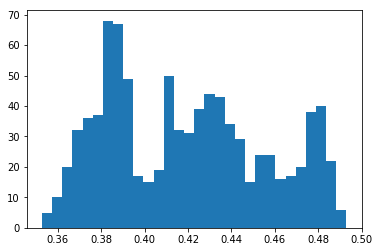

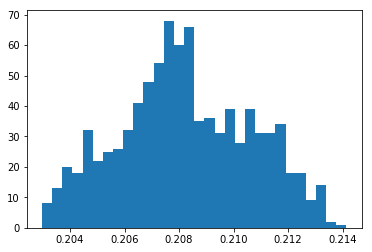

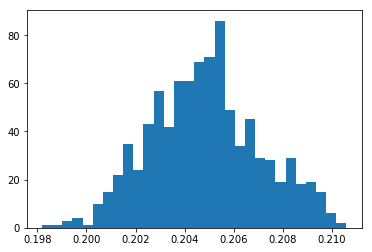

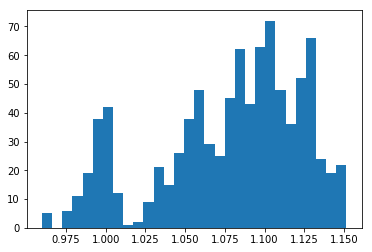

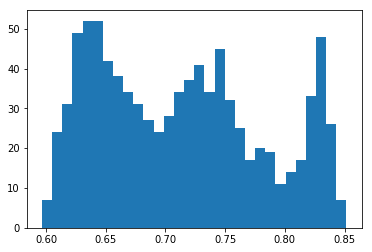

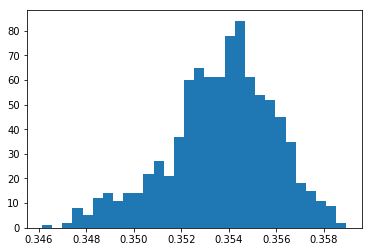

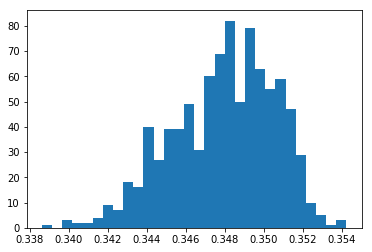

In [9]:
begin = 0
end = -1

nBin = 30

plt.hist(chain.getSamples("betaMild")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("betaHigh")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("mild0")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("high0")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("delay")[begin:end], nBin)
plt.show()
plt.hist(chain.getSamples("missedDeaths")[begin:end], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousVals")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousVals")[begin:end, 3], nBin)
plt.show()

plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 0], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 1], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 2], nBin)
plt.show()
plt.hist(chain.getSamples("discontinuousValsBeta")[begin:end, 3], nBin)
plt.show()


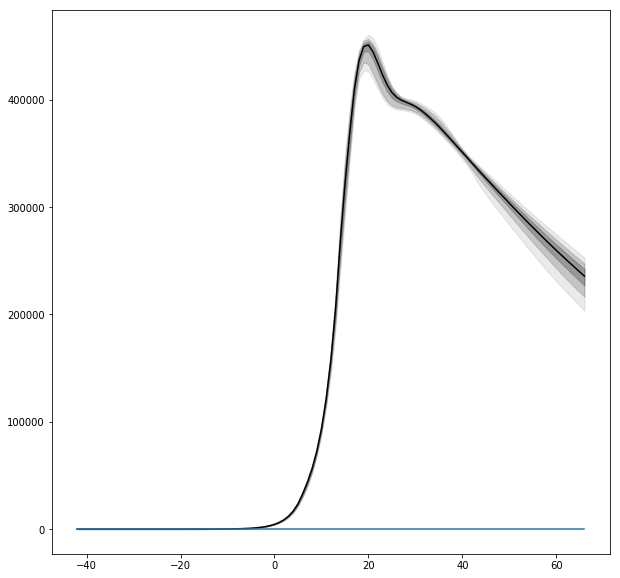

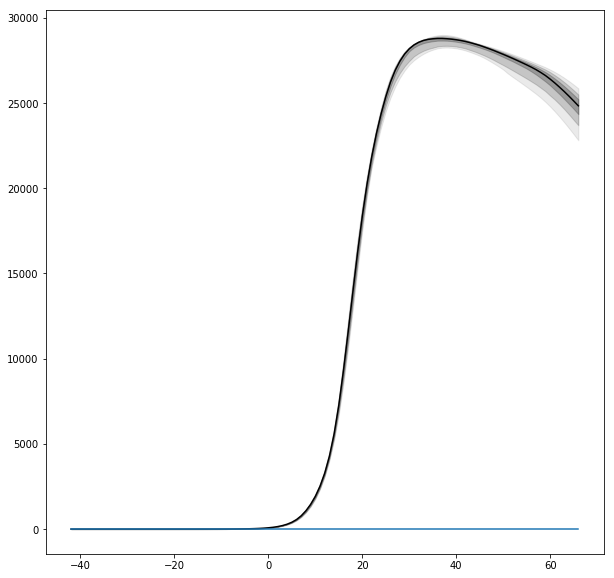

ValueError: x and y must have same first dimension, but have shapes (109,) and (1,)

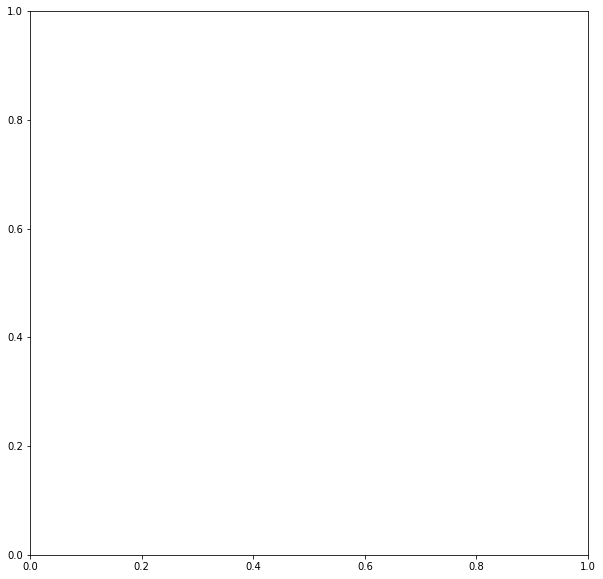

In [12]:
def myplot(name): 

    plt.figure(figsize=(10,10))
    y = np.median(chain.getSamples(name)[:,:],0)
    lower1 = np.percentile(chain.getSamples(name)[:,:], (100-68.27)/2, axis=0)
    lower2 = np.percentile(chain.getSamples(name)[:,:], (100-95.45)/2, axis=0)
    lower3 = np.percentile(chain.getSamples(name)[:,:], (100-99.73)/2, axis=0)
    upper1 = np.percentile(chain.getSamples(name)[:,:], 100-(100-68.27)/2, axis=0)
    upper2 = np.percentile(chain.getSamples(name)[:,:], 100-(100-95.45)/2, axis=0)
    upper3 = np.percentile(chain.getSamples(name)[:,:], 100-(100-99.73)/2, axis=0)
    plt.plot(time_all, y, 'k')
    fc = '#333333'
    ec = fc # '#000000'
    plt.plot(time_all,np.ones(time_all.shape))
    plt.fill_between(time_all, lower1, upper1, alpha=0.3, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower2, upper2, alpha=0.2, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.fill_between(time_all, lower3, upper3, alpha=0.1, facecolor=fc, edgecolor=ec, antialiased=True)
    plt.show()
    
myplot("mild")
myplot("serious")
myplot("R")
myplot("dead")
myplot("recovered")